In [1]:
import os
import flwr as fl
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from opacus import PrivacyEngine
from collections import OrderedDict
from flwr.common import NDArrays, Scalar
from typing import Dict, Optional, Tuple
from typing import List


2024-06-25 22:36:24.088465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 22:36:25.861510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset = pd.read_csv(r"PUDF_base1q2009_tab.csv")
dataset = dataset.dropna()
dataset = dataset.drop(['RECORD_ID','PAT_AGE','PAT_STATUS'],axis=1)
dataset['SEX_CODE'] = pd.Categorical(dataset['SEX_CODE']).codes
dataset['ADMITTING_DIAGNOSIS'] = pd.Categorical(dataset['ADMITTING_DIAGNOSIS']).codes
dataset['PRINC_DIAG_CODE'] = pd.Categorical(dataset['PRINC_DIAG_CODE']).codes
dataset['OTH_DIAG_CODE_1'] = pd.Categorical(dataset['OTH_DIAG_CODE_1']).codes
dataset['OCCUR_DAY_1'] = pd.Categorical(dataset['OCCUR_DAY_1']).codes
dataset['OCCUR_CODE_1'] = pd.Categorical(dataset['OCCUR_CODE_1']).codes
dataset['HCFA_MDC'] = pd.Categorical(dataset['HCFA_MDC']).codes
dataset['ETHNICITY'] = pd.Categorical(dataset['ETHNICITY']).codes
dataset['SOURCE_OF_ADMISSION'] = pd.Categorical(dataset['SOURCE_OF_ADMISSION']).codes
dataset['RACE'] = pd.Categorical(dataset['RACE']).codes
dataset['LENGTH_OF_STAY'] = pd.Categorical(dataset['LENGTH_OF_STAY']).codes
dataset['TYPE_OF_ADMISSION'] = pd.Categorical(dataset['TYPE_OF_ADMISSION']).codes
dataset['APR_MDC'] = pd.Categorical(dataset['APR_MDC']).codes
dataset['HCFA_DRG'] = pd.Categorical(dataset['HCFA_DRG']).codes
dataset['APR_DRG'] = pd.Categorical(dataset['APR_DRG']).codes
dataset['ILLNESS_SEVERITY'] = pd.Categorical(dataset['ILLNESS_SEVERITY']).codes
dataset['RISK_MORTALITY'] = pd.Categorical(dataset['RISK_MORTALITY']).codes
RISK_MORTALITY_MAP = {1:0,2:1,3:2,4:3}
dataset['RISK_MORTALITY'] = dataset['RISK_MORTALITY'].replace(RISK_MORTALITY_MAP)

data = {
  "RISK_MORTALITY": [0,1,2,3],
  "Clients": [len(dataset.query("RISK_MORTALITY == 0")),
              len(dataset.query("RISK_MORTALITY == 1")),
              len(dataset.query("RISK_MORTALITY == 2")),
              len(dataset.query("RISK_MORTALITY == 3"))]
}

df = pd.DataFrame(data)
sm_dataset_0 = dataset.query("RISK_MORTALITY == 0").iloc[1:60000]
sm_dataset_1 = dataset.query("RISK_MORTALITY == 1").iloc[1:60000]
sm_dataset_2 = dataset.query("RISK_MORTALITY == 2").iloc[1:60000]
sm_dataset_3 = dataset.query("RISK_MORTALITY == 3").iloc[1:60000]
sm_dataset = pd.concat([sm_dataset_0, sm_dataset_1, sm_dataset_2, sm_dataset_3])

X_train_1 = sm_dataset_0.to_numpy()[1:60000,:]
X_train_2 = sm_dataset_1.to_numpy()[1:10000,:]
X_train_3 = sm_dataset_2.to_numpy()[1:10000,:]
X_train_4 = sm_dataset_3.to_numpy()[1:10000,:]
X_train_5 =np.concatenate((X_train_1,X_train_2,X_train_3,X_train_4),axis=0)

smt = KMeansSMOTE(random_state=42)
X = X_train_5[:,:16]
y = X_train_5[:,-1]
X_train_5, y_train_5 = smt.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_train_5,y_train_5, random_state=104,test_size=0.5,shuffle=True)

scaler = MinMaxScaler()
label_encoder = LabelEncoder()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
label_encoder.fit(y_train)
label_encoder.fit(y_test)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)   

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

#X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#y_train_tensor = torch.tensor(y_train, dtype=torch.long)
#X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create data loaders
#train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


/tmp/ipykernel_3855257/4024044755.py:1: DtypeWarning: Columns (1,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(r"PUDF_base1q2009_tab.csv")
/home/dgxuser49/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/home/dgxuser49/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/home/dgxuser49/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._c

(119997, 16)
(119997, 16)
(119997,)
(119997,)


In [5]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(16, 16)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(16, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(32, 16)
        self.dropout4 = nn.Dropout(0.3)
        self.fc5 = nn.Linear(16, 4)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        x = self.softmax(x)
        return x    
    
# Instantiate the model
model = NeuralNet()
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
privacy_engine = PrivacyEngine()
# Set privacy parameters
model, optimizer, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=0.001,
    max_grad_norm=1.0,
  )


In [6]:
checkpoint_dir = 'DP-CNN_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
f2 = open("DP-TEXAS-4_1.csv", "a")
f2.write(f"Epoch,Loss,Accuracy,Val_Loss,Val_Accuracy\n")

42

In [7]:
def train(model, train_loader, epochs=35):
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        model = model.to(device)
        model.train()
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            print(f"Loss:{loss}")
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += target.size(0)
            correct += (torch.max(outputs.data, 1)[1] == target).sum().item()
        epoch_loss /= len(train_loader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss:.8f}, accuracy {epoch_acc}")
        f = open("train_texas_35_1.txt", "a")
        f.write(f"Epoch: {epoch+1} Loss: {epoch_loss:.8f}, Accuracy: {epoch_acc:.8f}\n")
        f.close()
        test_correct, test_total, test_loss = 0, 0, 0

        with torch.no_grad():
            for test_data, test_target in test_loader:
                test_data = test_data.to(device)
                test_target = test_target.to(device)
                test_outputs = model(test_data)
                test_loss += criterion(test_outputs, test_target).item()
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_total += test_target.size(0)
                test_correct += (test_predicted == test_target).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy = test_correct / test_total
        print(f'Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')
        f1 = open("test_texas_35_1.txt", "a")
        f1.write(f"Loss: {test_loss:.8f}, Accuracy: {test_accuracy:.8f}\n")
        f1.close()
        f2.write(f"{epoch+1},{epoch_loss:.8f},{epoch_acc:.8f},{test_loss:.4f},{test_accuracy:.8f}\n")
    f2.close()
    return model


In [8]:
trained_model = train(model, train_loader, epochs=35)

checkpoint_path = os.path.join(checkpoint_dir, f'TEXAS_DP_epoch_35_1.pth')
torch.save(trained_model, checkpoint_path)
print(f"Model checkpoint saved at {checkpoint_path}")

/home/dgxuser49/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Loss:1.3916352987289429
Loss:1.386614441871643
Loss:1.3872038125991821
Loss:1.3884328603744507
Loss:1.3873008489608765
Loss:1.3804274797439575
Loss:1.386181116104126
Loss:1.38468337059021
Loss:1.3890912532806396
Loss:1.3844960927963257
Loss:1.3844380378723145
Loss:1.3874356746673584
Loss:1.3855804204940796
Loss:1.387026071548462
Loss:1.3871792554855347
Loss:1.3858932256698608
Loss:1.38701593875885
Loss:1.3839300870895386
Loss:1.3831857442855835
Loss:1.3835989236831665
Loss:1.3881771564483643
Loss:1.3804446458816528
Loss:1.3890475034713745
Loss:1.3866205215454102
Loss:1.3872395753860474
Loss:1.3875828981399536
Loss:1.3856966495513916
Loss:1.386094570159912
Loss:1.388665795326233
Loss:1.3903188705444336
Loss:1.387056589126587
Loss:1.3833023309707642
Loss:1.386258840560913
Loss:1.3866056203842163
Loss:1.387024998664856
Loss:1.3869746923446655
Loss:1.3897372484207153
Loss:1.3829268217086792
Loss:1.3856534957885742
Loss:1.3832612037658691
Loss:1.3865190744400024
Loss:1.3844273090362549
Loss

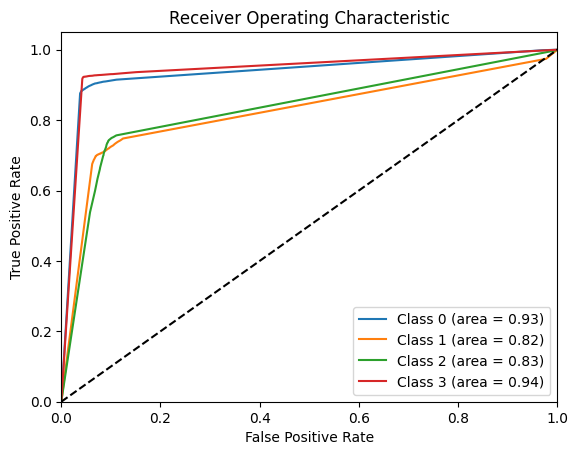

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     30019
           1       0.77      0.70      0.73     30152
           2       0.72      0.74      0.73     29850
           3       0.87      0.92      0.90     29976

    accuracy                           0.81    119997
   macro avg       0.81      0.81      0.81    119997
weighted avg       0.81      0.81      0.81    119997



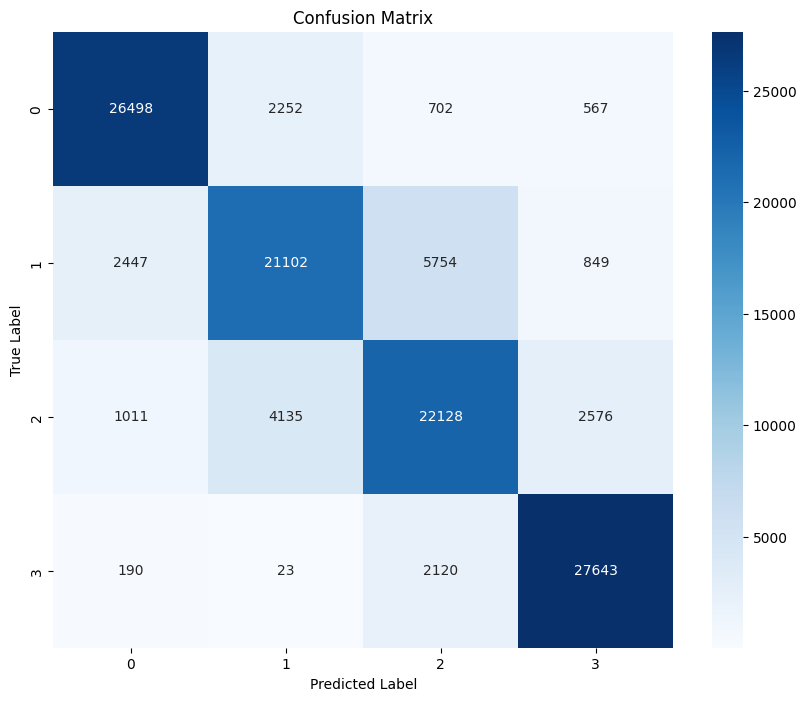

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

if __name__ == "__main__":
    checkpoint_path = os.path.join(checkpoint_dir, f'TEXAS_DP_epoch_35_1.pth')
    TEXAS_model =torch.load(checkpoint_path)

    TEXAS_model = TEXAS_model.to(device)
    TEXAS_model.eval()
    
    # Initialize lists to store true labels and predictions
    true_labels = []
    pred_probs = []
    
    # Make predictions
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = TEXAS_model(data)
            probabilities = torch.softmax(outputs, dim=1)
            pred_probs.extend(probabilities.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    true_labels = np.array(true_labels)
    pred_probs = np.array(pred_probs)
    pred_labels = np.argmax(pred_probs, axis=1)
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    num_classes=4
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels == i, pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    class_names=['0','1','2','3']
    print(classification_report(true_labels, pred_labels, target_names=class_names))
    
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

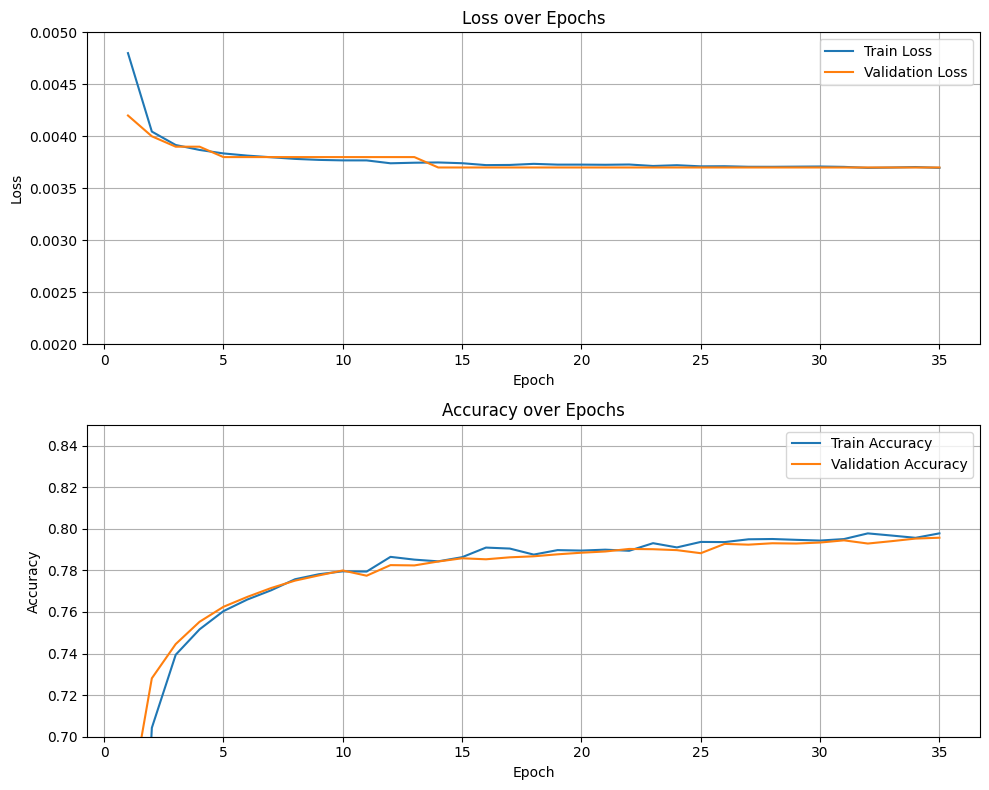

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
file_path = 'DP-TEXAS-4_1.csv'  # Replace with the actual path to your CSV file
data = pd.read_csv(file_path)

# Extract relevant columns
epochs = data['Epoch']
train_loss = data['Loss']
train_accuracy = data['Accuracy']
val_loss = data['Val_Loss']
val_accuracy = data['Val_Accuracy']

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot loss values
ax1.plot(epochs, train_loss, label='Train Loss')
ax1.plot(epochs, val_loss, label='Validation Loss')
ax1.set_ylim([0.002, 0.005])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Epochs')
ax1.legend()
ax1.grid(True)

# Plot accuracy values
ax2.plot(epochs, train_accuracy, label='Train Accuracy')
ax2.plot(epochs, val_accuracy, label='Validation Accuracy')
ax2.set_ylim([0.7, 0.85])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.legend()
ax2.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
